In [508]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.impute import SimpleImputer
from pandas.api.types import is_numeric_dtype
import yfinance as yf

In [509]:
#os.chdir('..')
df = pd.read_csv('data/database_reddit_sentiment.csv', sep=';', decimal='.', encoding='utf-8')
df['Date'] = pd.to_datetime(df['Date'])

In [510]:
# imput nan and fill "0.0"
for col in df.columns:
    if is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(df[col].mean())
        df[col] = np.where(df[col] == 0.0, df[col].mean(), df[col])

In [526]:
df['RATIO_POS_NEG'] = df['POSITIVE'] - df['NEGATIVE']
df['RATIO_POS_NEG_7'] = df['RATIO_POS_NEG'].rolling(5).mean()
df['RATIO_POS_NEG_14'] = df['RATIO_POS_NEG'].rolling(10).mean()

In [527]:
sp500 = yf.Ticker('^GSPC')
hist = sp500.history(period='max', interval='1d')

In [528]:
hist = hist.reset_index()

In [529]:
hist['Date'] = pd.to_datetime(hist['Date'])

In [530]:
df = df.merge(hist[['Date', 'Close']], how='left', on='Date')
df['Close'] = df['Close'].interpolate(method='nearest')

KeyError: 'Close'

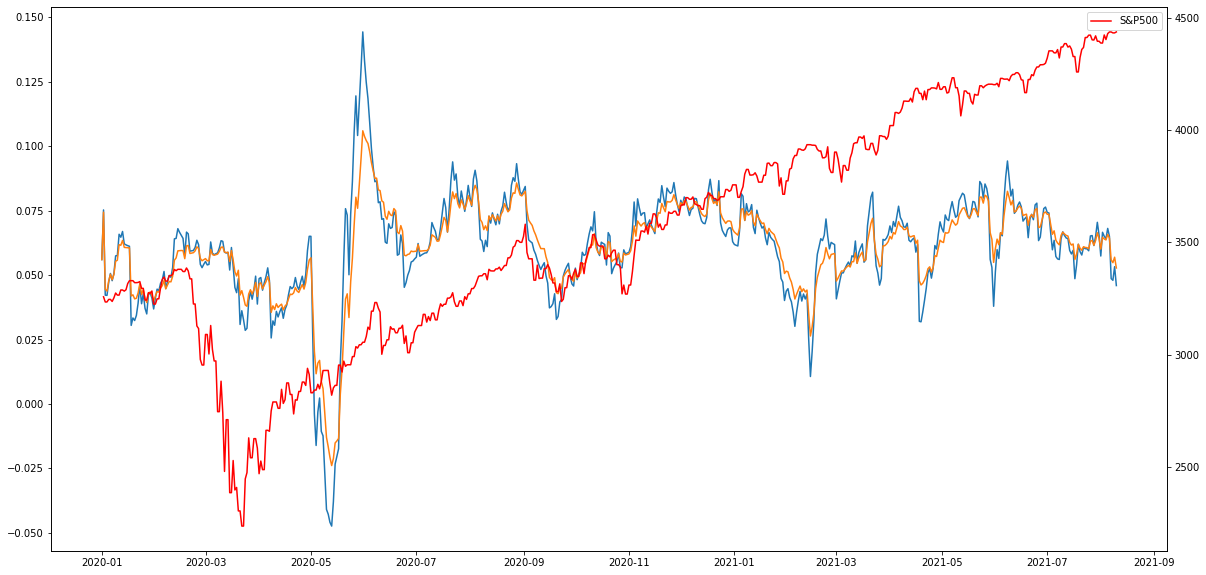

In [516]:
fig,ax = plt.subplots(figsize=(20,10))
plt.plot(df.Date, df['RATIO_POS_NEG_7'], label='RATIO_POS_NEG_7')
plt.plot(df.Date, df['RATIO_POS_NEG_14'], label='RATIO_POS_NEG_14')

ax2=ax.twinx()
plt.plot(df.Date, df['Close'], '-r', label='S&P500')

plt.legend()
plt.show()

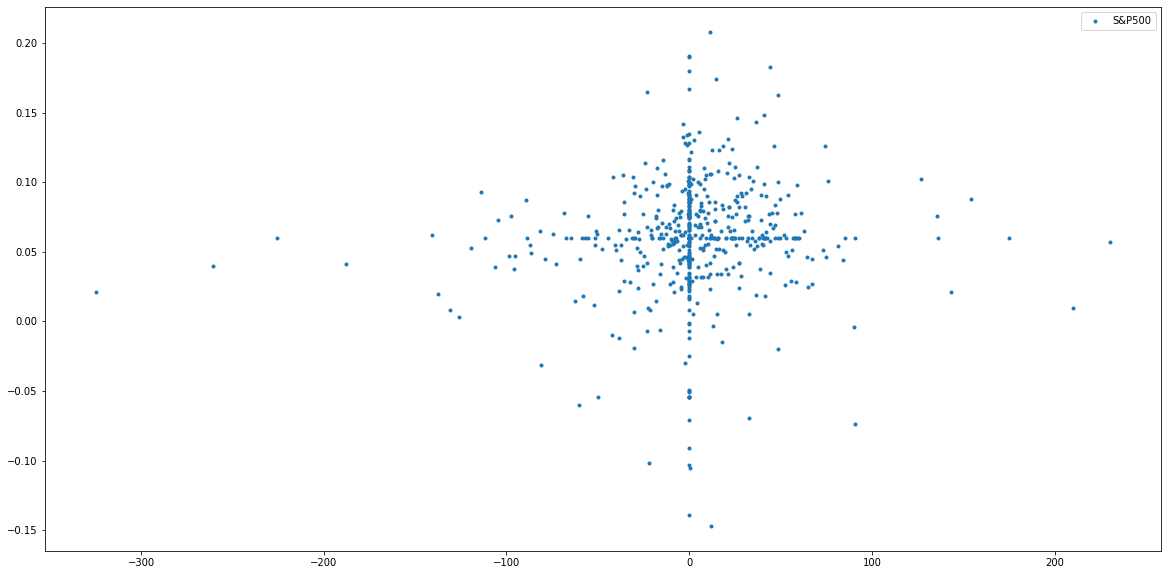

In [525]:
fig,ax = plt.subplots(figsize=(20,10))
plt.plot(df['Close'].diff(), df['RATIO_POS_NEG'], '.', label='S&P500')

plt.legend()
plt.show()

In [517]:
# find zero crossings
zero_crossings = np.where( np.diff( np.sign(np.array((df['RATIO_POS_NEG_7']-df['RATIO_POS_NEG_14']).rolling(7).mean()) ) ) )[0]
aux = df.iloc[zero_crossings]
aux = aux[aux.RATIO_POS_NEG_7.notna() & aux.RATIO_POS_NEG_14.notna()]

# buy and sell indicator
aux['action'] = np.where( (aux['RATIO_POS_NEG_7']-aux['RATIO_POS_NEG_14']).diff() > 0, 'buy', 'sell')

# filter to zero crossing where the short term sentiment goes positive (==buy)
aux_buy = aux[aux['action'] == 'buy']
aux_sell = aux[aux['action'] == 'sell']


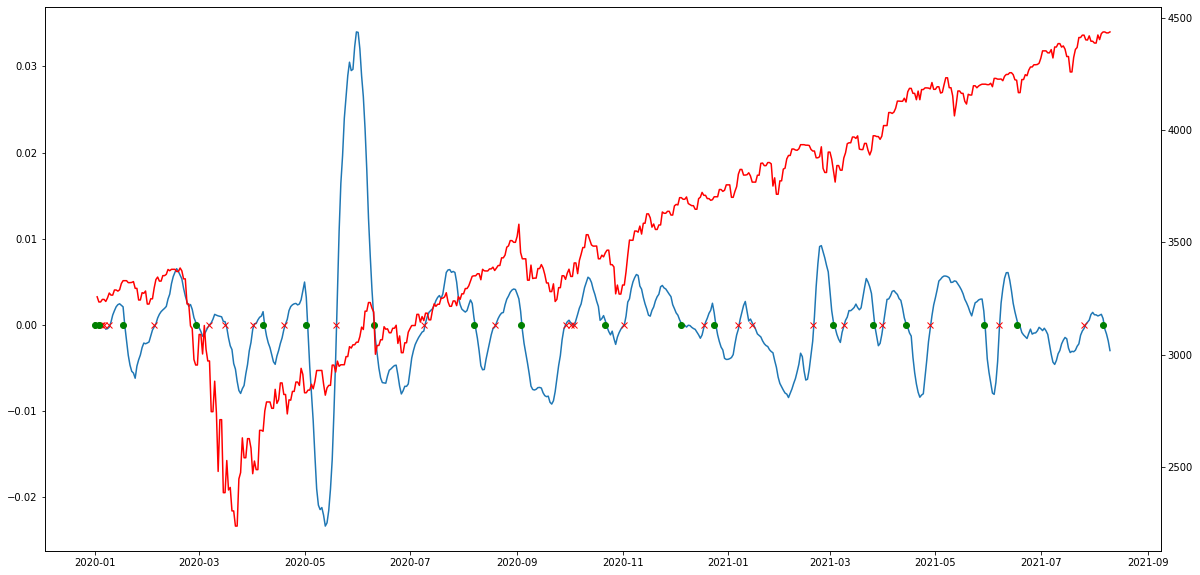

In [518]:
fig,ax = plt.subplots(figsize=(20,10))

plt.plot(df.Date, (df['RATIO_POS_NEG_7']-df['RATIO_POS_NEG_14']).rolling(7).mean())
plt.plot(aux_buy.Date, [0.0 for x in range(len(aux_buy))], 'xr', label='buy')
plt.plot(aux_sell.Date, [0.0 for x in range(len(aux_sell))], 'og', label='sell')

ax2=ax.twinx()
plt.plot(df.Date, df['Close'], '-r', label='S&P500')

plt.show()

In [519]:
# simulate buy and sell actions
hold_price = None
total_gain = 0.0
transaction_cost = 1.0
for index, row in aux.iterrows():
    if (row['action'] == 'buy') and (hold_price == None):
        hold_price = row['Close']
        total_gain = total_gain - transaction_cost
        print('Bought at {}'.format(hold_price))
    
    if (row['action'] == 'sell') and (hold_price != None):
        gain = row['Close'] - hold_price
        if gain > 0: # of course we sell only when we make a profit
            total_gain = total_gain + gain - transaction_cost
            hold_price = None
            print('Sold at {} with gain/loss: {}'.format(row['Close'], gain))
print('Total gain/loss sentiment: {}'.format(total_gain))

# passive strategy buy at begin and sell at end
gain = df[-1:]['Close'].values[0] - df.dropna()[:1]['Close'].values[0]
print('Total gain/loss naive: {}'.format(gain))


Bought at 3257.85009765625
Sold at 3329.6201171875 with gain/loss: 71.77001953125
Bought at 3297.590087890625
Sold at 3351.280029296875 with gain/loss: 53.68994140625
Bought at 3374.85009765625
Sold at 3455.06005859375 with gain/loss: 80.2099609375
Bought at 3335.469970703125
Sold at 3453.489990234375 with gain/loss: 118.02001953125
Bought at 3310.239990234375
Sold at 3699.1201171875 with gain/loss: 388.880126953125
Bought at 3709.409912109375
Sold at 3819.719970703125 with gain/loss: 110.31005859375
Bought at 3875.43994140625
Sold at 3974.5400390625 with gain/loss: 99.10009765625
Bought at 3972.889892578125
Sold at 4124.66015625 with gain/loss: 151.770263671875
Bought at 4183.18017578125
Sold at 4204.10986328125 with gain/loss: 20.9296875
Bought at 4226.52001953125
Sold at 4436.52001953125 with gain/loss: 210.0
Total gain/loss sentiment: 1284.68017578125
Total gain/loss naive: 1178.89990234375


In [520]:
import spacy

nlp = spacy.load("en_core_web_sm")
#doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
doc = nlp("I will buy APPL stocks today because they will sell lots of iPhones")

txt = ("Given the recent downturn in stocks especially in tech which is likely to persist as yields keep going up, "
       "I thought it would be prudent to share the risks of investing in ARK ETFs, written up very nicely by "
       "[The Bear Cave](https://thebearcave.substack.com/p/special-edition-will-ark-invest-blow). The risks comes "
       "primarily from ARK's illiquid and very large holdings in small cap companies. ARK is forced to sell its "
       "holdings whenever its liquid ETF gets hit with outflows as is especially the case in market downturns. "
       "This could force very painful liquidations at unfavorable prices and the ensuing crash goes into a "
       "positive feedback loop leading into a death spiral enticing even more outflows and predatory shorts.")
doc = nlp(txt)

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

ARK 172 175 ORG
The Bear 209 217 WORK_OF_ART
ARK 329 332 ORG
ARK 392 395 ORG
